In [1]:
#!/usr/bin/python3
# -*- coding: utf-8 -*-
# @Time    : 2023/3/27 21:48
# @Author  : Genius_limeng
# @FileName: train.py
# @Software: PyCharm
import random
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, AveragePooling2D
from keras.optimizers import SGD,adam
from keras.utils import np_utils
from keras.models import load_model
from keras import backend as K
from load_dataset import load_dataset, resize_image
from keras.models import Model
from sklearn.metrics import classification_report
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

IMAGE_SIZE = 128

# 加载数据类
class Dataset:
    def __init__(self, path_name):
        # 训练集
        self.train_images = None
        self.train_labels = None
        # 验证集
        self.valid_images = None
        self.valid_labels = None
        # 测试集
        self.test_images = None
        self.test_labels = None
        # 数据集加载路径
        self.path_name = path_name
        # 图像种类
        self.user_num = len(os.listdir(path_name))
        # 当前库采用的维度顺序
        self.input_shape = None

    # 加载数据集并按照交叉验证的原则划分数据集并进行相关预处理工作
    def load(self, img_rows=IMAGE_SIZE, img_cols=IMAGE_SIZE, img_channels=3):
        # 数据种类
        nb_classes = self.user_num
        # 加载数据集到内存
        images, labels = load_dataset(self.path_name)

        train_images, valid_images, train_labels, valid_labels = train_test_split(images, labels, test_size=0.3,
                                                           random_state=random.randint(0, 100))
        _, test_images, _, test_labels = train_test_split(images, labels, test_size=0.3,
                                                           random_state=random.randint(0, 100))

        # 当前的维度顺序如果为'th'，则输入图片数据时的顺序为：channels,rows,cols，否则:rows,cols,channels
        # 这部分代码就是根据keras库要求的维度顺序重组训练数据集
        if K.image_dim_ordering() == 'th':
            train_images = train_images.reshape(train_images.shape[0], img_channels, img_rows, img_cols)
            valid_images = valid_images.reshape(valid_images.shape[0], img_channels, img_rows, img_cols)
            test_images = test_images.reshape(test_images.shape[0], img_channels, img_rows, img_cols)
            self.input_shape = (img_channels, img_rows, img_cols)
        else:
            train_images = train_images.reshape(train_images.shape[0], img_rows, img_cols, img_channels)
            valid_images = valid_images.reshape(valid_images.shape[0], img_rows, img_cols, img_channels)
            test_images = test_images.reshape(test_images.shape[0], img_rows, img_cols, img_channels)
            self.input_shape = (img_rows, img_cols, img_channels)

            # 输出训练集、验证集、测试集的数量
            print(train_images.shape[0], 'train samples')
            print(valid_images.shape[0], 'valid samples')
            print(test_images.shape[0], 'test samples')

            # 我们的模型使用categorical_crossentropy作为损失函数，因此需要根据类别数量nb_classes将
            # 类别标签进行one-hot编码使其向量化，在这里我们的类别只有4种，经过转化后标签数据变为二维
            train_labels = np_utils.to_categorical(train_labels, nb_classes)
            valid_labels = np_utils.to_categorical(valid_labels, nb_classes)
            test_labels = np_utils.to_categorical(test_labels, nb_classes)

            # 像素数据浮点化以便归一化
            train_images = train_images.astype('float32')
            valid_images = valid_images.astype('float32')
            test_images = test_images.astype('float32')

            # 将其归一化,图像的各像素值归一化到0~1区间
            train_images /= 255
            valid_images /= 255
            test_images /= 255

            self.train_images = train_images
            self.valid_images = valid_images
            self.test_images = test_images
            self.train_labels = train_labels
            self.valid_labels = valid_labels
            self.test_labels = test_labels


# CNN网络模型类
class Model:
    def __init__(self):
        self.model = None
        self.history = None

        # 建立模型

    def build_model(self, dataset, nb_classes=4):
        # 构建一个空的网络模型，它是一个线性堆叠模型，各神经网络层会被顺序添加，专业名称为序贯模型或线性堆叠模型
        self.model = Sequential()
        # 以下代码将顺序添加CNN网络需要的各层，一个add就是一个网络层
        # -------------------------------1--------------------------------------
        self.model.add(Convolution2D(32, 3, 3, border_mode='same',
                                     input_shape=dataset.input_shape))  # 32维卷积层
        self.model.add(Convolution2D(32, 3, 3, border_mode='same'))  # 32维卷积层
        self.model.add(Activation('relu'))
        self.model.add(MaxPooling2D(pool_size=(2, 2)))  # 最大池化层
        self.model.add(Dropout(0.25))  # Dropout层
        # -------------------------------2--------------------------------------
        self.model.add(Convolution2D(64, 3, 3, border_mode='same'))  # 64维卷积层
        self.model.add(Convolution2D(64, 3, 3, border_mode='same'))  # 64维卷积层
        self.model.add(Activation('relu'))
        self.model.add(MaxPooling2D(pool_size=(2, 2)))  # 最大池化层
        self.model.add(Dropout(0.25))  # Dropout层
        # -------------------------------3--------------------------------------
        self.model.add(Convolution2D(128, 3, 3, border_mode='same'))  # 128维卷积层
        self.model.add(Convolution2D(128, 3, 3, border_mode='same'))  # 128维卷积层
        self.model.add(Convolution2D(128, 3, 3, border_mode='same'))  # 128维卷积层
        self.model.add(Activation('relu'))
        self.model.add(MaxPooling2D(pool_size=(2, 2)))  # 最大池化层
        self.model.add(Dropout(0.25))  # Dropout层
        # -------------------------------4--------------------------------------
        self.model.add(Convolution2D(256, 3, 3, border_mode='same'))  # 256维卷积层
        self.model.add(Convolution2D(256, 3, 3, border_mode='same'))  # 256维卷积层
        self.model.add(Convolution2D(256, 3, 3, border_mode='same'))  # 256维卷积层
        self.model.add(Activation('relu'))
        self.model.add(MaxPooling2D(pool_size=(2, 2)))  # 最大池化层
        self.model.add(Dropout(0.25))  # Dropout层
        # -------------------------------5--------------------------------------
        self.model.add(Convolution2D(256, 3, 3, border_mode='same'))  # 256维卷积层
        self.model.add(Convolution2D(256, 3, 3, border_mode='same'))  # 256维卷积层
        self.model.add(Convolution2D(256, 3, 3, border_mode='same'))  # 256维卷积层
        self.model.add(Activation('relu'))
        self.model.add(MaxPooling2D(pool_size=(2, 2)))  # 最大池化层
#         self.model.add(AveragePooling2D(pool_size=(2, 2), strides=2))  # 平均池化层
        self.model.add(Dropout(0.25))  # Dropout层
        # -------------------------------6--------------------------------------
        self.model.add(Flatten())  # Flatten层
        self.model.add(Dense(256))  # Dense层,又被称作全连接层
        self.model.add(Activation('relu'))
        self.model.add(Dropout(0.5))  # Dropout层
        self.model.add(Dense(nb_classes))  # Dense层
        self.model.add(Activation('softmax'))  # 分类层，输出最终结果

        # 输出模型概况
        self.model.summary()

    # 编译配置模型
    def compile(self):
        # 使用SGD作为反向传播的优化器，来使损失函数最小化，学习率(learning_rate)
        # 是0.01，学习率衰减因子(decay)
        # 用来随着迭代次数不断减小学习率，防止出现震荡。引入冲量(momentum), 不仅可以在学习率较小的时候加速学习，又可以在学习率较大的时候减速，
        # 不使用数据提升，所谓的提升就是从我们提供的训练数据中利用旋转、翻转、加噪声等方法创造新的
        # 训练数据，有意识的提升训练数据规模，增加模型训练量
        sgd = SGD(lr=0.0001, decay=1e-6,  # 10的-6次方
                  momentum=0.8, nesterov=True)  # 采用SGD+momentum的优化器进行训练，首先生成一个优化器对象
        Adam = adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
        self.model.compile(loss='categorical_crossentropy',
                           optimizer=sgd,
                           metrics=['accuracy'])  # 完成实际的模型配置工作

    # 训练模型
    def train(self, dataset, batch_size=20, nb_epoch=20, data_augmentation=True):

        if not data_augmentation:
            self.history = self.model.fit(dataset.train_images,
                                          dataset.train_labels,
                                          batch_size=batch_size,
                                          nb_epoch=nb_epoch,
                                          validation_data=(dataset.valid_images, dataset.valid_labels),
                                          shuffle=True)
        # 使用实时数据提升
        else:
            # 定义数据生成器用于数据提升，其返回一个生成器对象datagen，datagen每被调用一
            # 次其生成一组数据（顺序生成），节省内存，其实就是python的数据生成器
            datagen = ImageDataGenerator(
                featurewise_center=False,  # 是否使输入数据去中心化（均值为0），
                samplewise_center=False,  # 是否使输入数据的每个样本均值为0
                featurewise_std_normalization=False,  # 是否数据标准化（输入数据除以数据集的标准差）
                samplewise_std_normalization=False,  # 是否将每个样本数据除以自身的标准差
                zca_whitening=False,  # 是否对输入数据施以ZCA白化
                rotation_range=20,  # 数据提升时图片随机转动的角度(范围为0～180)
                width_shift_range=0.2,  # 数据提升时图片水平偏移的幅度（单位为图片宽度的占比，0~1之间的浮点数）
                height_shift_range=0.2,  # 同上，只不过这里是垂直
                horizontal_flip=True,  # 是否进行随机水平翻转
                vertical_flip=False)  # 是否进行随机垂直翻转

            # 计算整个训练样本集的数量以用于特征值归一化、ZCA白化等处理
            datagen.fit(dataset.train_images)

            # 利用生成器开始训练模型
            self.history = self.model.fit_generator(datagen.flow(dataset.train_images, dataset.train_labels,
                                                                 batch_size=batch_size),
                                                    samples_per_epoch=dataset.train_images.shape[0],
                                                    nb_epoch=nb_epoch,
                                                    validation_data=(dataset.valid_images, dataset.valid_labels))

    MODEL_PATH = './model/CNN-FaceRecognitionModel.h5'

    # 保存模型
    def save_model(self, file_path=MODEL_PATH):
        self.model.save(file_path)

    # 加载模型
    def load_model(self, file_path=MODEL_PATH):
        self.model = load_model(file_path)

    # 输出模型评价曲线
    def evaluate(self, dataset):
        score = self.model.evaluate(dataset.test_images, dataset.test_labels, batch_size=20, verbose=1)
        print("%s: %.2f%%" % (self.model.metrics_names[1], score[1] * 100))
        print("score:", score)
        plt.plot(self.history.history['acc'])
        plt.plot(self.history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()

        plt.plot(self.history.history['loss'])
        plt.plot(self.history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()

    # 输出混淆矩阵
    def predict(self, dataset):
        prob = self.model.predict(dataset.test_images)
        predIdxs = np.argmax(prob, axis=1)
        print('\n')
        print(classification_report(dataset.test_labels.argmax(axis=1), predIdxs,
                                     =['faces_other','LiMeng', 'ShiWei', 'YangXinYe', 'ZhengLiWei'], digits=5))

    # 输出热力图
    def heatmap(self, dataset):
        prob = self.model.predict(dataset.test_images)
        predIdxs = np.argmax(prob, axis=1)
        cm = confusion_matrix(dataset.test_labels.argmax(axis=1), predIdxs)
        sns.heatmap(cm, annot=True)
        plt.title('Confusion matrix')
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')
        plt.show()
    # 识别人脸
    def face_predict(self, image):
        # 依然是根据后端系统确定维度顺序
        if K.image_dim_ordering() == 'th' and image.shape != (1, 3, IMAGE_SIZE, IMAGE_SIZE):
            image = resize_image(image)  # 尺寸必须与训练集一致都应该是IMAGE_SIZE x IMAGE_SIZE
            image = image.reshape((1, 3, IMAGE_SIZE, IMAGE_SIZE))  # 与模型训练不同，这次只是针对1张图片进行预测
        elif K.image_dim_ordering() == 'tf' and image.shape != (1, IMAGE_SIZE, IMAGE_SIZE, 3):
            image = resize_image(image)
            image = image.reshape((1, IMAGE_SIZE, IMAGE_SIZE, 3))

        # 浮点并归一化
        image = image.astype('float32')
        image /= 255

        # 给出输入属于各个类别的概率
        result_probability = self.model.predict_proba(image)
        print('result:', result_probability)

        # 给出类别预测(改）
        if max(result_probability[0]) >= 0.8:
            result = self.model.predict_classes(image)
            print('result:', result)
            # 返回类别预测结果
            return result[0]
        else:
            print('result:none')
            return -1

SyntaxError: invalid syntax (800453467.py, line 246)

In [5]:
if __name__ == '__main__':
    user_num = len(os.listdir('./dataset/'))
    # print("识别成员人数：", user_num, "人")
    dataset = Dataset('./dataset/')
    dataset.load()
    cnn = Model()
    cnn.build_model(dataset, nb_classes=user_num)
    cnn.compile()  # 完成实际的模型配置工作
    # 开始训练
    cnn.train(dataset)
    # 保存模型
    cnn.save_model(file_path='./model/CNN-FaceRecognitionModel.h5')

36373 train samples
15589 valid samples
15589 test samples


C:\Users\limeng\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:115: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(128, 128,..., padding="same")`
C:\Users\limeng\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:116: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same")`
C:\Users\limeng\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:121: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same")`
C:\Users\limeng\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:122: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same")`
C:\Users\limeng\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:127: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same")`
C:\Users\limeng\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:128: UserWa

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 128, 128, 32)      9248      
_________________________________________________________________
activation_2 (Activation)    (None, 128, 128, 32)      0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 64, 64, 64)        36928     
__________

C:\Users\limeng\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:207: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
C:\Users\limeng\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:207: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., steps_per_epoch=1818, epochs=20)`


Epoch 1/20
1818/1818 [==============================] - 164s 90ms/step - loss: 1.2440 - acc: 0.5390 - val_loss: 1.2831 - val_acc: 0.6378
Epoch 2/20
1818/1818 [==============================] - 152s 84ms/step - loss: 0.9507 - acc: 0.6319 - val_loss: 0.9635 - val_acc: 0.6784
Epoch 3/20
1818/1818 [==============================] - 150s 83ms/step - loss: 0.7966 - acc: 0.6872 - val_loss: 0.7528 - val_acc: 0.7732
Epoch 4/20
1818/1818 [==============================] - 160s 88ms/step - loss: 0.7087 - acc: 0.7277 - val_loss: 0.8690 - val_acc: 0.6642
Epoch 5/20
1818/1818 [==============================] - 155s 85ms/step - loss: 0.6311 - acc: 0.7644 - val_loss: 0.5631 - val_acc: 0.8323
Epoch 6/20
1818/1818 [==============================] - 153s 84ms/step - loss: 0.5546 - acc: 0.7996 - val_loss: 0.5457 - val_acc: 0.8058
Epoch 7/20
1818/1818 [==============================] - 152s 84ms/step - loss: 0.4817 - acc: 0.8270 - val_loss: 0.3507 - val_acc: 0.8905
Epoch 8/20
1818/1818 [===================

15589/15589 [==============================] - 18s 1ms/step
acc: 98.73%
score: [0.04902047472949644, 0.9872987334131315]


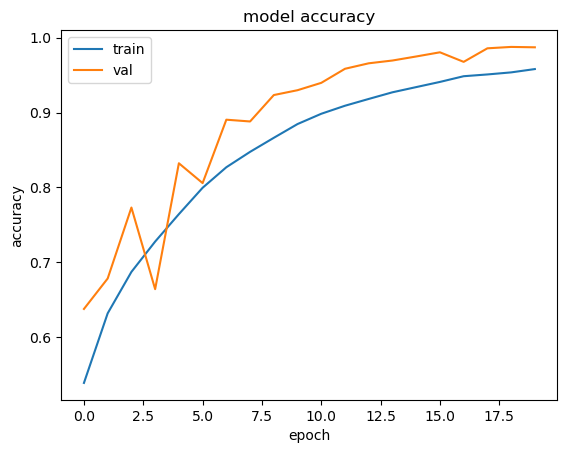

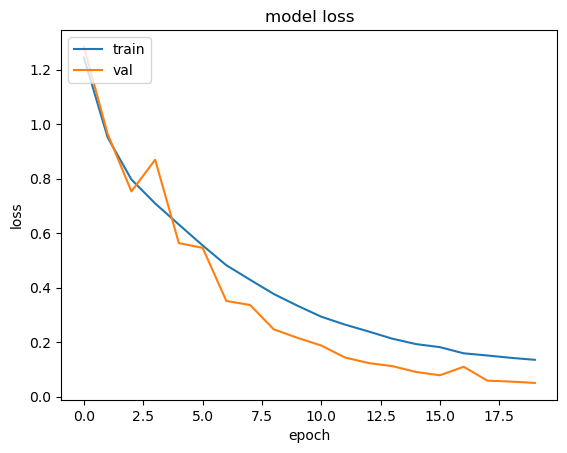

In [11]:
    # 准确率曲线图
    cnn.evaluate(dataset)

In [9]:
    # 混淆矩阵
    cnn.predict(dataset)



              precision    recall  f1-score   support

      LiMeng    0.99976   0.99030   0.99501      8455
      ShiWei    0.94357   0.99945   0.97071      1807
   YangXinYe    0.97567   0.96064   0.96809      1753
  ZhengLiWei    0.97920   0.98459   0.98189      1817
 faces_other    0.99542   0.98976   0.99258      1757

    accuracy                        0.98730     15589
   macro avg    0.97872   0.98495   0.98166     15589
weighted avg    0.98765   0.98730   0.98736     15589



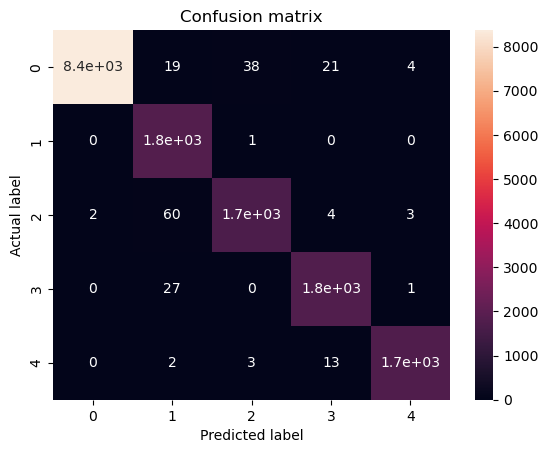

In [10]:
    # 热力图
    cnn.heatmap(dataset)